[Logisitic Regression Code](https://github.com/ctkatz/ctkatz.github.io/blob/main/posts/blog-7/logistic.py)

## Abstract

In this blog post, I implement logisitic regression and gradient descent and test in on a series of data, some simulated and some real world data. We find that logistic regression is a great method for binary classification, especially when we play around with the momentum term beta. increasing the momentum term makes the algorithim more efficent when it optimizes each step.

In [386]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Expirements

### Data and plotting setup

In [387]:
import torch
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(n_points = 300, noise = 0.2 ,p_dims =2)

In [388]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the decision boundaries
def plot_decision_boundary(X, y, w):
    plt.figure(figsize=(4, 3))

    colors = ['RED', 'BLUE']

    # Scatter plot of the data points with consistent colors
    for label in [0, 1]:
        plt.scatter(X[y == label, 0], X[y == label, 1], 
                    color=colors[label], label=f'Class {label}', edgecolor='k', alpha=0.7)

    # Create a grid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Ensure w is a NumPy array and flatten it
    w = np.array(w).flatten()

    # Predict over the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    if len(w) == 3:  # Assuming w includes a bias term
        preds = np.dot(grid, w[:-1]) + w[-1]
    else:
        preds = np.dot(grid, w)
    preds = preds.reshape(xx.shape)

    # Plot the shaded regions with simple colors
    plt.contourf(xx, yy, preds > 0, alpha=0.3, colors=['RED', 'BLUE'])

    # Plot the decision boundary (line where prediction is zero)
    plt.contour(xx, yy, preds, levels=[0], colors="black", linewidths=2)

    plt.title("Decision Boundary with Shaded Regions")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# Plot the loss curve
def plot_loss(loss_vec):
    plt.figure(figsize=(4, 3))
    plt.plot(loss_vec, label="Loss")
    plt.title("Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


### Vanilla Gradient Descent
This first expirement tests the validity of the logisitic regression function by using simple data and no value of beta. This will help to demonstrate that the methods implemented work like they are supposed to

In [389]:
import torch
torch.manual_seed(1235)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

X, y = classification_data(n_points = 300, noise = 0.2 ,p_dims =2)
loss_vec = []


tensor([ 8.3854,  8.4834, -8.0724])


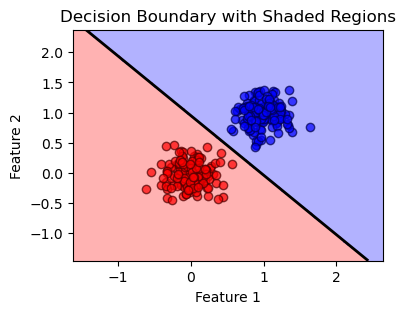

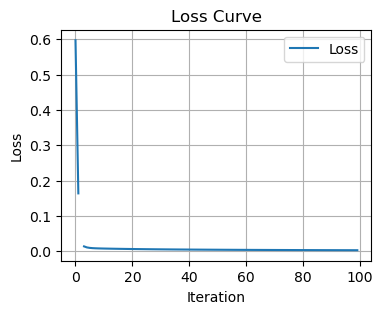

In [390]:
# Vanilla gradient descent
import numpy as np
import matplotlib.pyplot as plt
import torch


# Create figure for plotting decision boundary

# Run gradient descent
for i in range(100):
    loss = LR.loss(X, y)
    loss_vec.append(loss.item())  # Store the loss for plotting
    # Perform one step of gradient descent
    opt.step(X, y, alpha=0.1, beta=0)
w= LR.w
print(LR.w)

plot_decision_boundary(X, y, w)
plot_loss(loss_vec)


Here, we observe a weight vector that converges properly, dividing the data at a proper descision boundary. We also see clear monotonic loss decrease. All of this happens over 100 iterations of gradient descent (our optimizer), with a relativley low value of alpha and no momentum term (beta). This behavior is similar to what we saw in our perceptron algorithim. 

### Benefits of Momentum

In this expierement, I use the same data as above but play around with the momentum term to see the benefits of adding it. The expected result is faster convergene in the loss function.

tensor([ 12.2688,  12.6517, -12.0516])


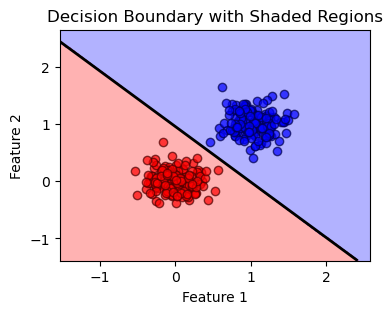

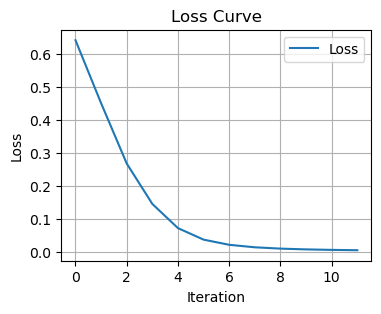

In [391]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

X, y = classification_data(n_points = 300, noise = 0.2 ,p_dims =2)


## Benefits of momentum
import numpy as np
import matplotlib.pyplot as plt
import torch

loss_vec = []
# Create figure for plotting decision boundary

# Run gradient descent
for i in range(100):
    loss = LR.loss(X, y)
    loss_vec.append(loss.item())  # Store the loss for plotting
    # Perform one step of gradient descent
    opt.step(X, y, alpha=0.01, beta=.9)
w= LR.w
print(LR.w)

plot_decision_boundary(X, y, w)
plot_loss(loss_vec)

When we add the momentum term of beta = .9, we find that the loss converges much faster than it did in the vanilla gradient descent, and a more accurate line dividing the two classes. This is because the momentum accelerates the process of graident descent by magnifing the differences between the current and previous weights.

### Overfitting

In this section, I explore the harms of overfitting by creating data with fewer points than dimensions. Then I run the training loop to understand the effects of overtraining by comparing it to testing data. I expect to see lower accuracy on the testing data due to overfitting.

In [392]:
## Overfitting data
import torch
def overfit_data(n_points = 50, noise = 0.5, p_dims = 100):
    y = torch.arange(n_points) >= int(n_points / 2)
    y = 1.0 * y
    X = y[:, None] + torch.normal(0.0, noise, size=(n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)  # Add bias term
    
    return X, y

X_train, y_train = overfit_data(n_points = 10, noise = 0.3 ,p_dims =100)

X_test, y_test = overfit_data(n_points = 10, noise = 0.3 ,p_dims =100)


In [393]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []
# Create figure for plotting decision boundary
accuracy= 0
# Run gradient descent
while accuracy < 1:
    loss = LR.loss(X_train, y_train)
    loss_vec.append(loss.item())  # Store the loss for plotting
    # Perform one step of gradient descent
    opt.step(X_train, y_train, alpha=0.1, beta=.1)
    y_pred = LR.predict(X_train)
    accuracy = (y_pred == y_train).float().mean().item()
w= LR.w
y_pred = LR.predict(X_train)

# Calculate accuracy

print(f'Training Accuracy: {accuracy * 100:.2f}%')

y_pred_test = LR.predict(X_test)

# Calculate accuracy on the testing data
accuracy_test = (y_pred_test == y_test).float().mean().item()
print(f'Testing Accuracy: {accuracy_test * 100:.2f}%')

Training Accuracy: 100.00%
Testing Accuracy: 70.00%


By setting the number of dimensions the data trains on to more points than the data has, we expierence overfitting. We see this because although the data is structured in the exact same way, we get much lower accuracy on the testing data. This is because we are intentionally training the model to fit into the nooks and crannies of the data in the training set which don't apply to the testing data

### Real World Data

In this section, I run my model on real world data. I use M Yasser H's dataset, which is data of every person who was on the titanic, their class, gender and other defining charecteristics and weather they lived or died. That status is what I use as the binary classifier. 

In [394]:
import pandas as pd
data= pd.read_csv("Titanic-Dataset.csv")

data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
X = data[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']
X = X.fillna(0)
target = 'Survived'
X.head()


,Pclass,Sex,SibSp,Parch,Fare
0,3,0,1,0,7.2500
1,1,1,1,0,71.2833
2,3,1,0,0,7.9250
3,1,1,1,0,53.1000
4,3,0,0,0,8.0500


Momentum:


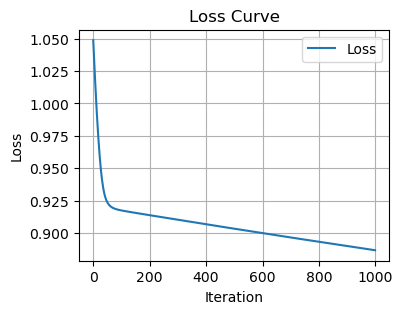

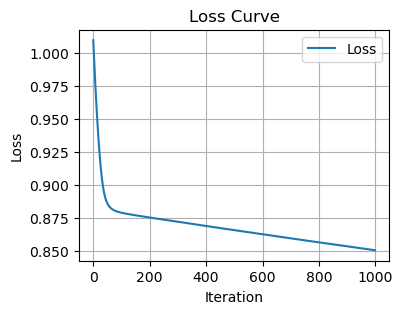

No Momentum:


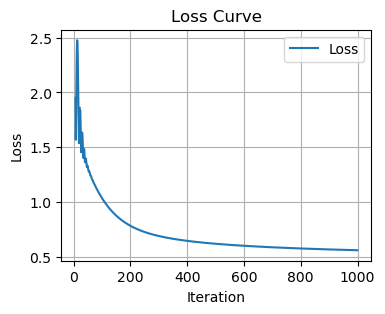

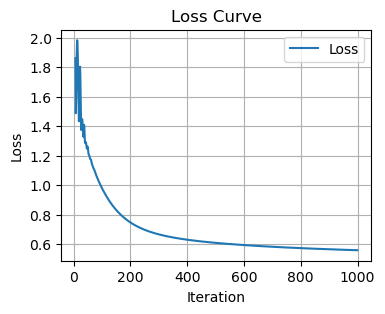

Test Accuracy: 72.07%
Testing Loss: 0.55


In [395]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
torch.manual_seed(13)
# Convert to tensors
X = torch.tensor(X.values, dtype=torch.float32)
#X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

y = torch.tensor(y.values, dtype=torch.float32)

# Flatten y to ensure it matches the simulated data
y = y.flatten()

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# initialize model and optimizer
LR = LogisticRegression()
#LR.w = torch.zeros((X_train.shape[1], 1), requires_grad=True)
opt = GradientDescentOptimizer(LR)

#track loss for training and validation
loss_vec = []
val_loss_vec = []

for i in range(1000):
    #calculate loss for training set
    loss = LR.loss(X_train, y_train)
    loss_vec.append(loss.item())  # Store the loss for plotting
    #print(loss)
    #calculate validation loss
    val_loss = LR.loss(X_val, y_val)
    val_loss_vec.append(val_loss.item())

    #perform one step of gradient descent
    opt.step(X_train, y_train, alpha=0.0000001, beta=0) 


# plot loss
print("Momentum:")
plot_loss(loss_vec)  # Training loss curve
plot_loss(val_loss_vec)  # Validation loss curve

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

#track loss for training and validation
loss_vec = []
val_loss_vec = []

# Run gradient descent
for i in range(1000):
    #calculate loss for training set
    loss = LR.loss(X_train, y_train)
    loss_vec.append(loss.item())  # Store the loss for plotting
    #print(loss)
    #calculate validation loss
    val_loss = LR.loss(X_val, y_val)
    val_loss_vec.append(val_loss.item())

    #perform one step of gradient descent
    opt.step(X_train, y_train, alpha=0.000001, beta=.9) 

# plot loss
print("No Momentum:")
plot_loss(loss_vec)  # Training loss curve
plot_loss(val_loss_vec)  # Validation loss curve

y_test_pred = LR.predict(X_test)
test_accuracy = (y_test_pred == y_test).float().mean().item()

# # Test accuracy
# y_test_pred = LR.predict(X_test)
# test_accuracy = (y_test_pred == y_test).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Testing Loss: {LR.loss(X_test, y_test):.2f}')


I was able to get a test accuracy of 72%, which is pretty solid. This means that in 72% of testing cases, the model correctly predicted weather someone on the ship lived or died based on factors like their class, their fare and their gender. I also run two different iterations, one that has momentum (the first one), and one with no momentum (the second one). We can see clearly that the equation with the momentum converges more quickly to a loss value over the same time period. We also see lower loss over the whole period for the non-momentum term.

## Discussion

In this blog post, I write and implement logisitic regression and graident descent. To test out these functions, I compute I plot the descision regions and comupte the scores and losses on different sets of data. We find that logisitic regression is optimal for doing binary classification tasks, even on real world data. We also see the benefits of momentum, and that adding a momentum term speeds up the process of gradient descent to arrive sooner at a higher accuracy.